# Detection et reconnaissance des couleurs des carrés
Dans ce notebook, nous présentons une technique de détection des carrées dans une image ainsi que l'extraction de la séquence de couleurs.

Pour exécuter ce notebook, nous utilisons les librairies :
- numpy
- opencv 3

Sur une raspberry pi, un bon tutorial concernant l'installation de ces librairies est présenté par jabelone:
https://github.com/jabelone/OpenCV-for-Pi

Le notebook est décrit comme suit :
- Sobel : détection basique des contours (juste pour la culture)
- Canny : détection poussée des contours (Basé sur l'article : A Computational Approach to Edge Detection, John Canny 1986 : IEEE Transactions on Pattern Analysis and Machine Intelligence) 
- Extraction des contours et approximation avec un polygone
- Filtrage des contours pouvant être décrites par 4 lignes
- Calcul du centre de chaque contour ainsi que le cercle circonscrit
- Filtrage par taille des rectangles
- Conversion en hsv 
- Extraction de la couleur moyenne sur un voisinage de chaque centre
- Organisation des réctangles de gauche à droite
- Création d'une liste des couleurs possibles
- Création d'une fonction calculant la distance de la teinte de deux couleurs (Hue du HSV)
- Vérification qu'on a 3 rectangles
- Pour chaque rectangle trouver la couleur la plus vraisemblable et afficher la séquence des couleurs.


On commance par importer les bibliothèques nécessaires :

In [419]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

On charge l'image à traiter et on la met en RGB (opencv charge les images en BGR par défaut)

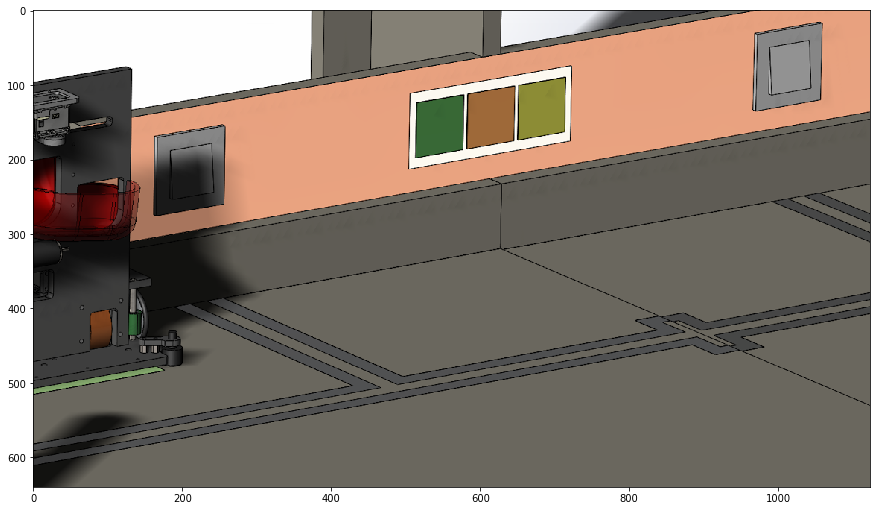

In [420]:
img_rw = cv2.imread("C:/Users/aloui_000/Documents/grebot/rectangles_extractor/Setup.png")
img = cv2.cvtColor(img_rw, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(img)

On transforme l'image en gris (pour faire la détection des contours)

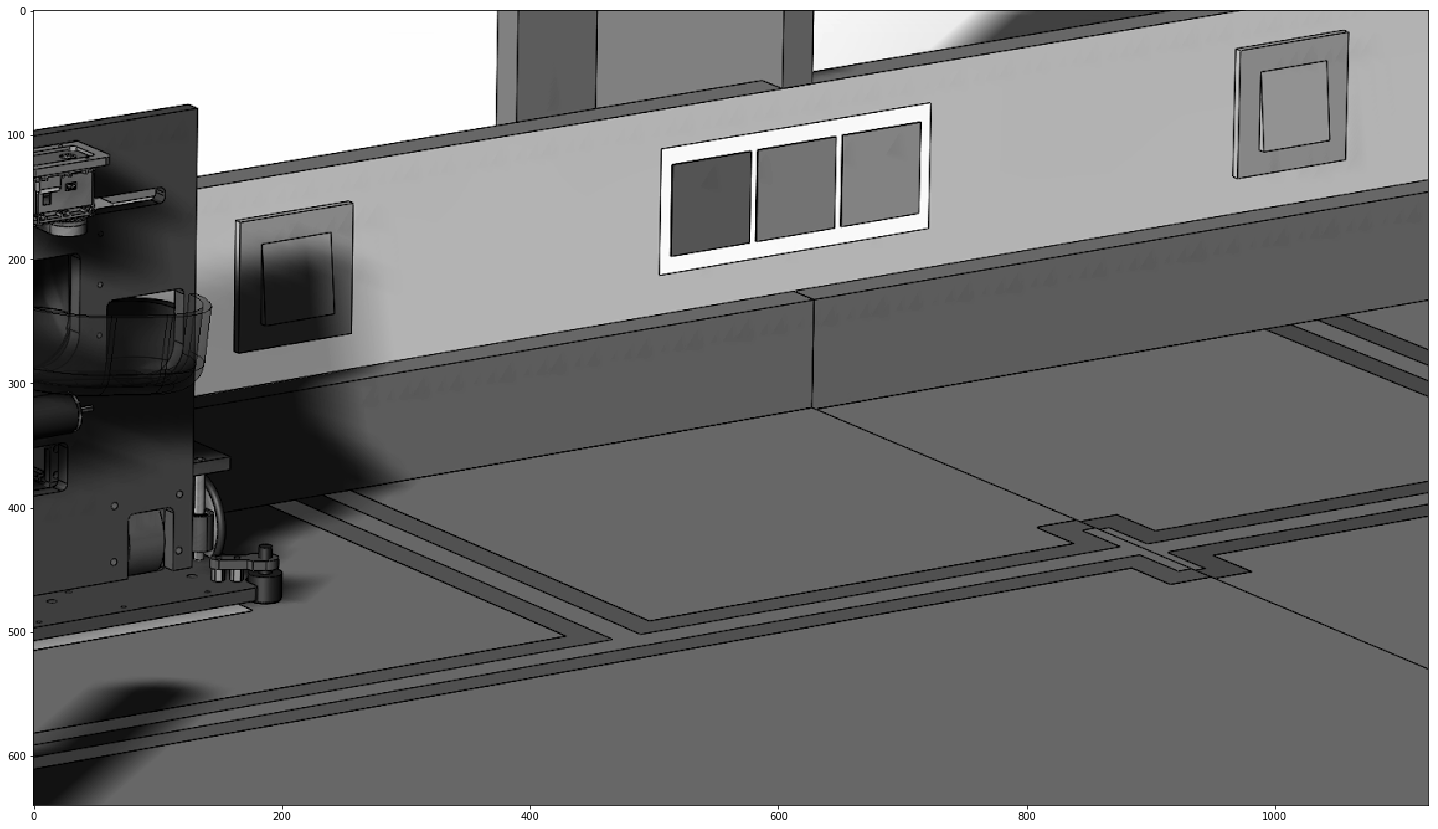

In [421]:
img_gray = cv2.cvtColor(img_rw, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (25,25))
plt.imshow(img_gray, cmap='gray')

On sature l'image afin d'accentuer la forme des patchs contenant les carrés 

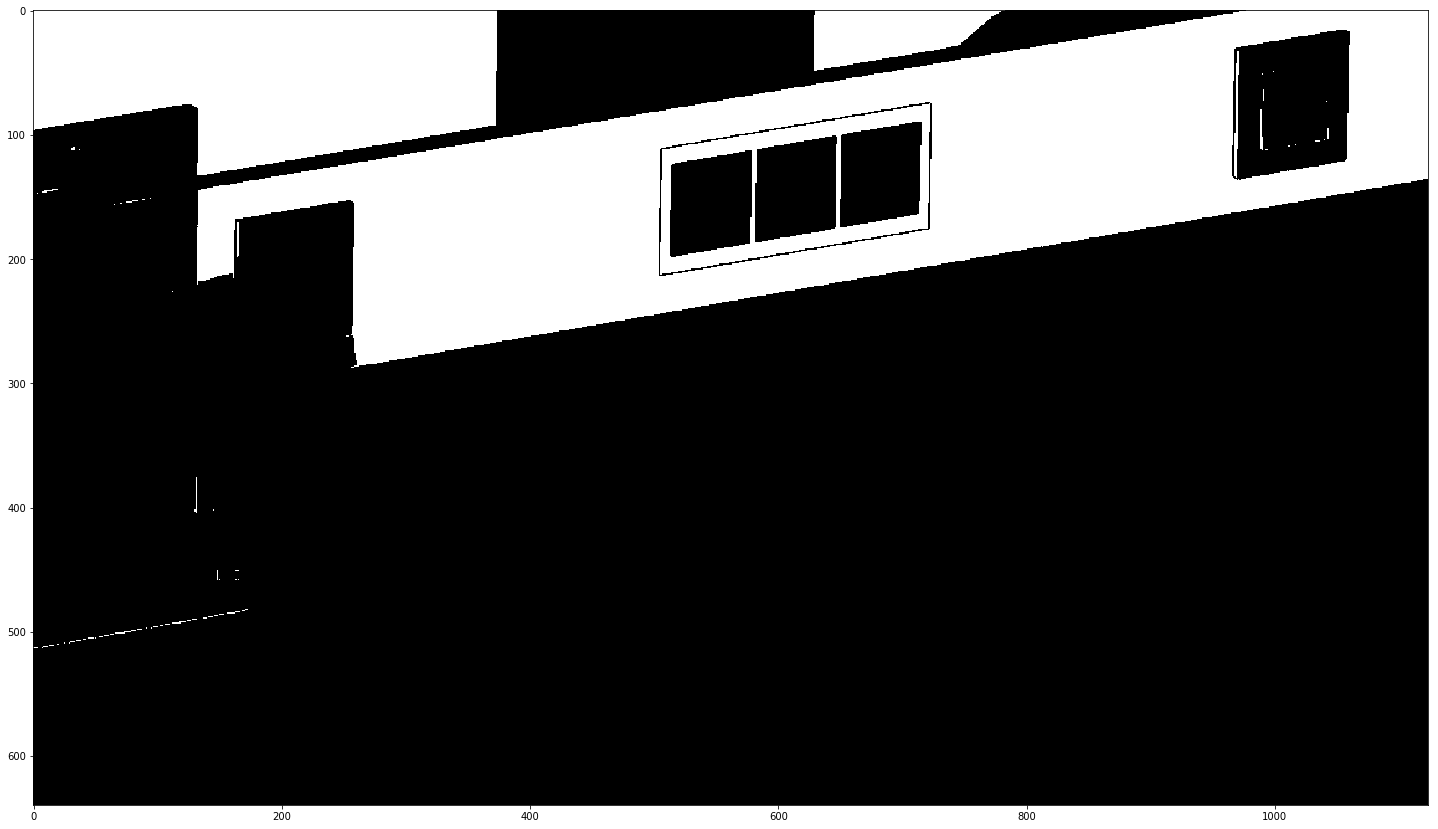

In [422]:
img_sat, mask = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
plt.figure(figsize = (25,25))
plt.imshow(mask, cmap='gray')

On la filtre afin de faciliter la détection des contours

# Sobel

Avant de faire des choses plus complexes, un clin d'oeul à la méthode de Sobel qui permet de trouver les lignes dans une image tout en calculant l'angle d'incidance.

La technique utilise une simple convolution avec le noyau suivant :


| Noyau Vertical|
| --- |:-:| --: |
| -1  | 0 | 1   |
| -2  | 0 | 2   |
| -1  | 0 | 1   |

Ce noyau permet de détecter les lignes verticales. Ceci nous donne une image $G_x$

Ensuite, on fait la même chose avec le noyau 


| Noyau Horizontal|
| --- |:-: | --:   |
| -1  | -2 | -1   |
|  0  | 0  | 0     |
|  1  | 2  | 1     |

Ce noyau permet de détecter les lignes horizontales. Ceci nous donne une image $G_y$

Pour trouver l'amplitude du gradient on utilise la formule :
$G = \sqrt{G_x^2+G_y^2}$

Pour trouver l'angle d'incidence on utilise la formule :
$A = atan(G_x/G_y)$

Cette méthode est limitée, elle donne une image qui contient des valeurs négatifs, qui doivent par conséquence être décalés pour donner une valeur entre 0 et 255 ce qui donne une image de contour contenant du gris partout sauf au niveau des contours.

Elle est sensible au bruit (en effet le petit filtrage bilatéral servait à atténuer cet effet)

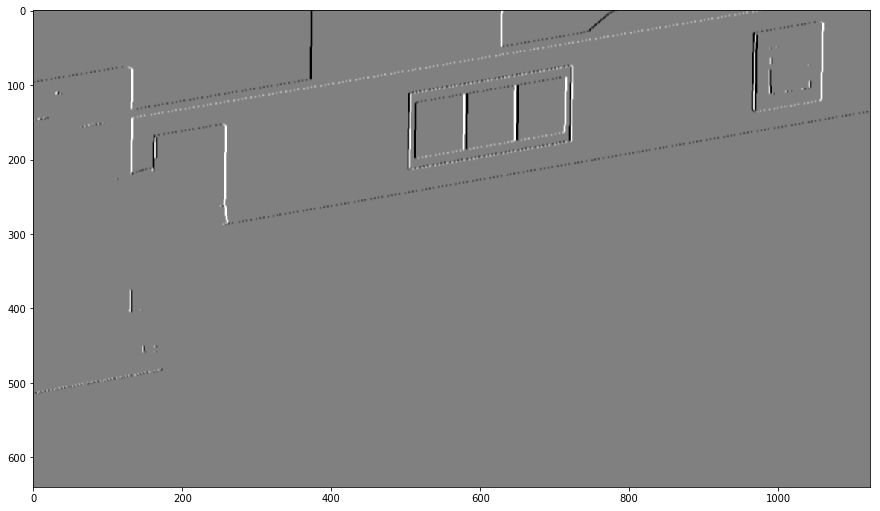

In [423]:
img_sobel = cv2.Sobel(mask,cv2.CV_64F,1,0,ksize=5)
plt.figure(figsize = (15,15))
plt.imshow(img_sobel, cmap='gray')

# Canny
Sobel est sympa, mais on peut faire mieux. En 1986, l'algo Canny (de john Canny) a été proposé et a réussi durant des années à rester parmis les algorithmes de détection de contour les plus efficaces.

Il s'agit d'une amélioration par rapport à Sobel.

Pour cet algo, on effectue donc du Sobel, mais par la suite, on utilise un seuillage afain de supprimer les artefacts et obtenir des lignes nets (une image noire avec des lignes blanches au lieu d'une image grie).
Cet algorithme est donc composé de deux parties 

## Extraction grossière des contours par l'algorithme de Sobel

Il s'agit sensiblement de l'algorithme de Sobel qui permet d'obtenir une image contenant une couleur grise partout sauf au niveau des contours. Ces derniers ne sont pas nets, et peuvent êtres blancs (très positifs), noirs (très négatifs) ou gris. Ces portions grises ne sont pas nets. Ils peuvent correspondre à de vrais contours ou à de simples artefacts.

Pour ceci, on utilise la deuxième partie.

## Raffinage des contours

Le raffinage est basé sur un seuillage sur la norme des pixels des contours.

Deux seuils sont utilisés :
- Le premier seuil "A" est celui à partir duquel un pixl d'un contour est accepté (on met une valeur de 1 ou 255 pour ce dernier, donc c'est simplement blanc). 
- Le deuxième seuil "B" sert à garder les points liés à des points de contours assez prononcés (permet ainsi de sauver les points qui sont souvent de vrais points de contours. Si le pixel a une valeur en dessous de ce seuil, on met systèmatiquement 0. S'il a une valeur entre le seuil "A" et le seuil "B", alors on vérifie si ce dernier est connecté à un point déjà accepté auquel cas on l'accepte (on met 1 ou 255), sinon on met 0.

A la fin on obtient une image noir et blanc, contenant du blanc au niveau des contours et 0 partout ailleur.


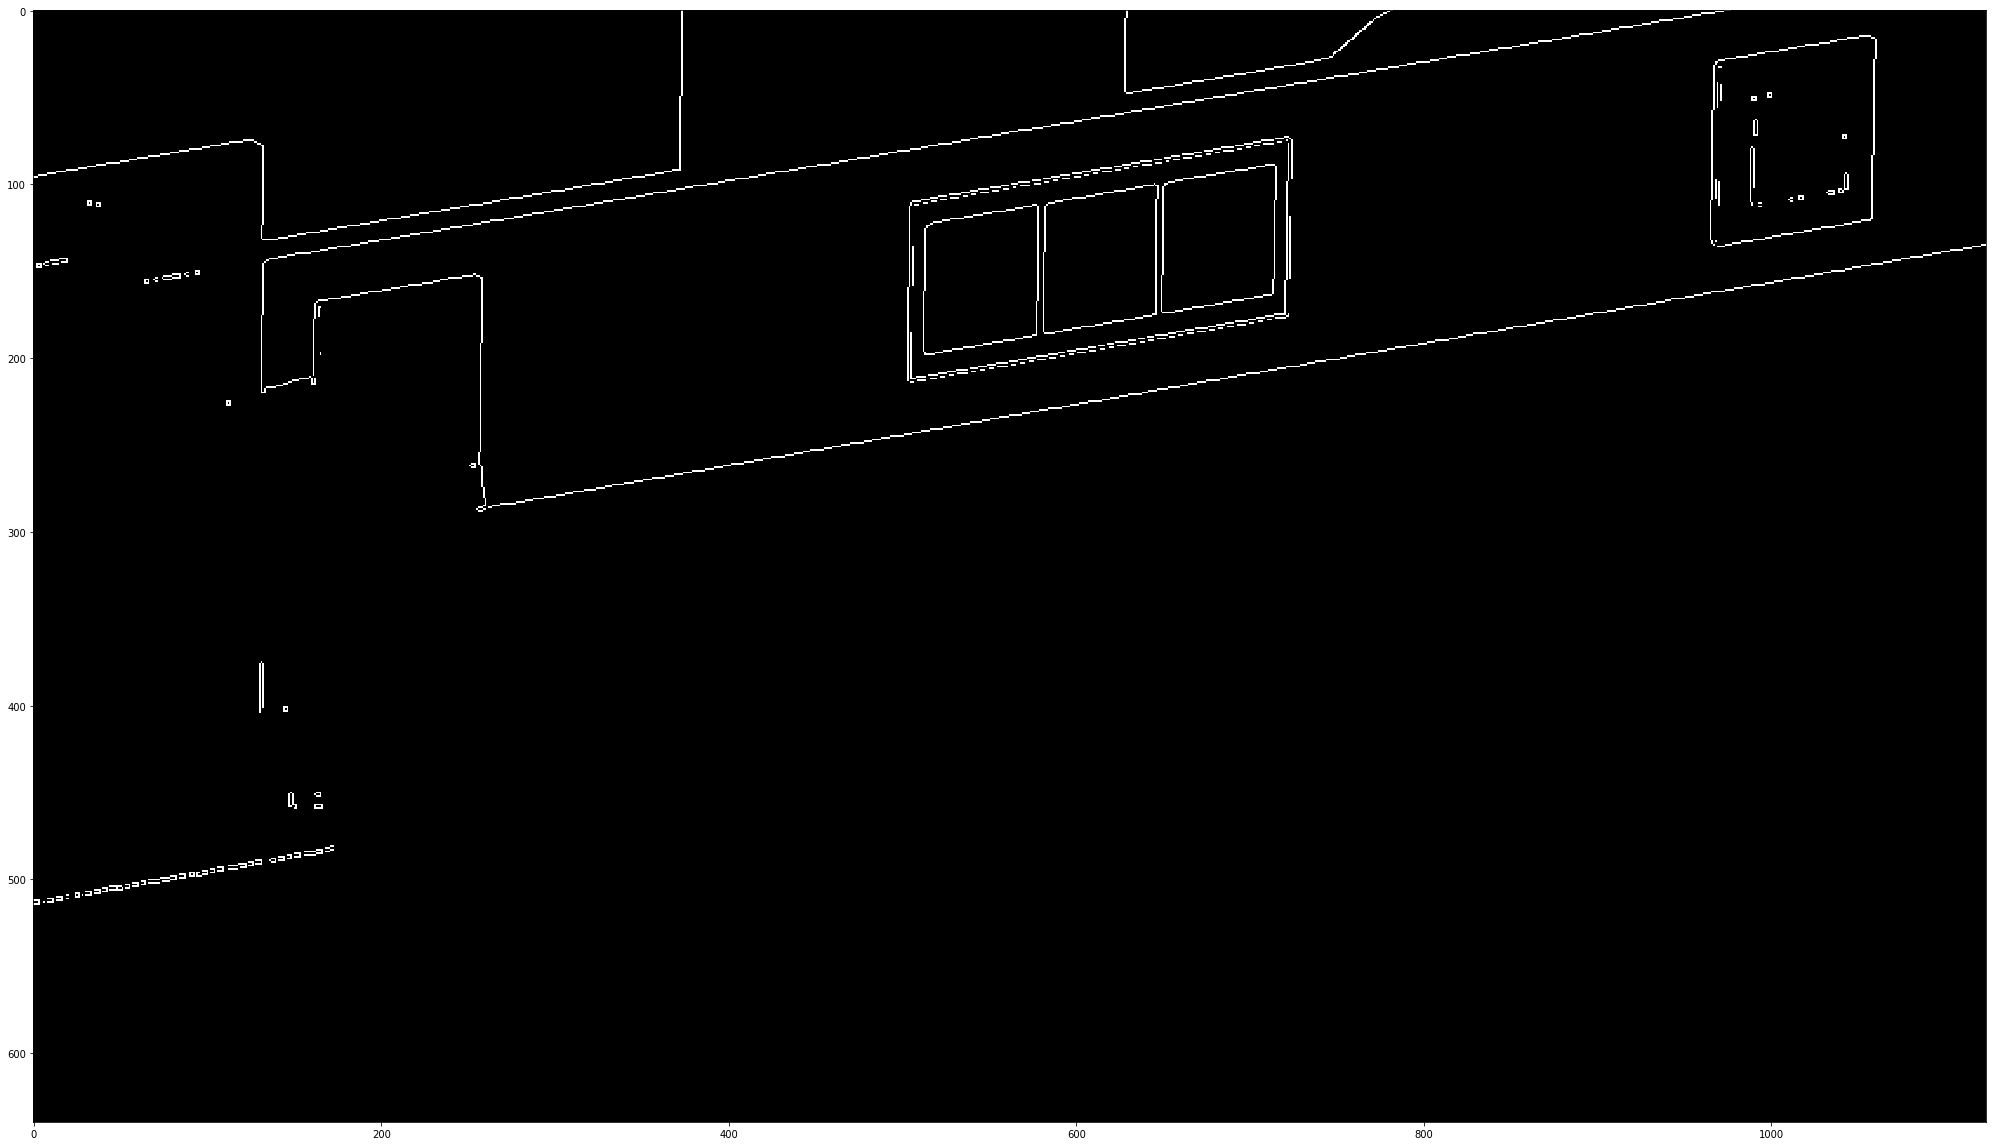

In [424]:
img_canny = cv2.Canny(mask, 150,200)
plt.figure(figsize = (35,35))
plt.imshow(img_canny, cmap='gray')

## Dilatation Erosion
L'érosion et la dilatation sont deux techniques très utilisées dans le traitement d'images.
### Erosion

Comme son nom l'indique, une  érosion a comme effet de supprimer les bords d'un objet (comme une érosion des cotes). Pour réaliser ceci, on effectue une convolution 2D avec un noyau, sauf que contrairement à un filtrage, on met 1 (ou 255) dans le pixel résultant si tous les prixels sous le noayau sont à 1 sinon elles sont érodées (mises à 0).

### Dilatation

Comme son nom l'indique, une  dilatation a comme effet de dilater les bords d'un objet. Pour réaliser ceci, on effectue une convolution 2D avec un noyau, sauf que contrairement à un filtrage, on met 1 (ou 255) dans le pixel résultant si au moins un prixel sous le noayau est à 1 sinon elles sont érodées (mises à 0).


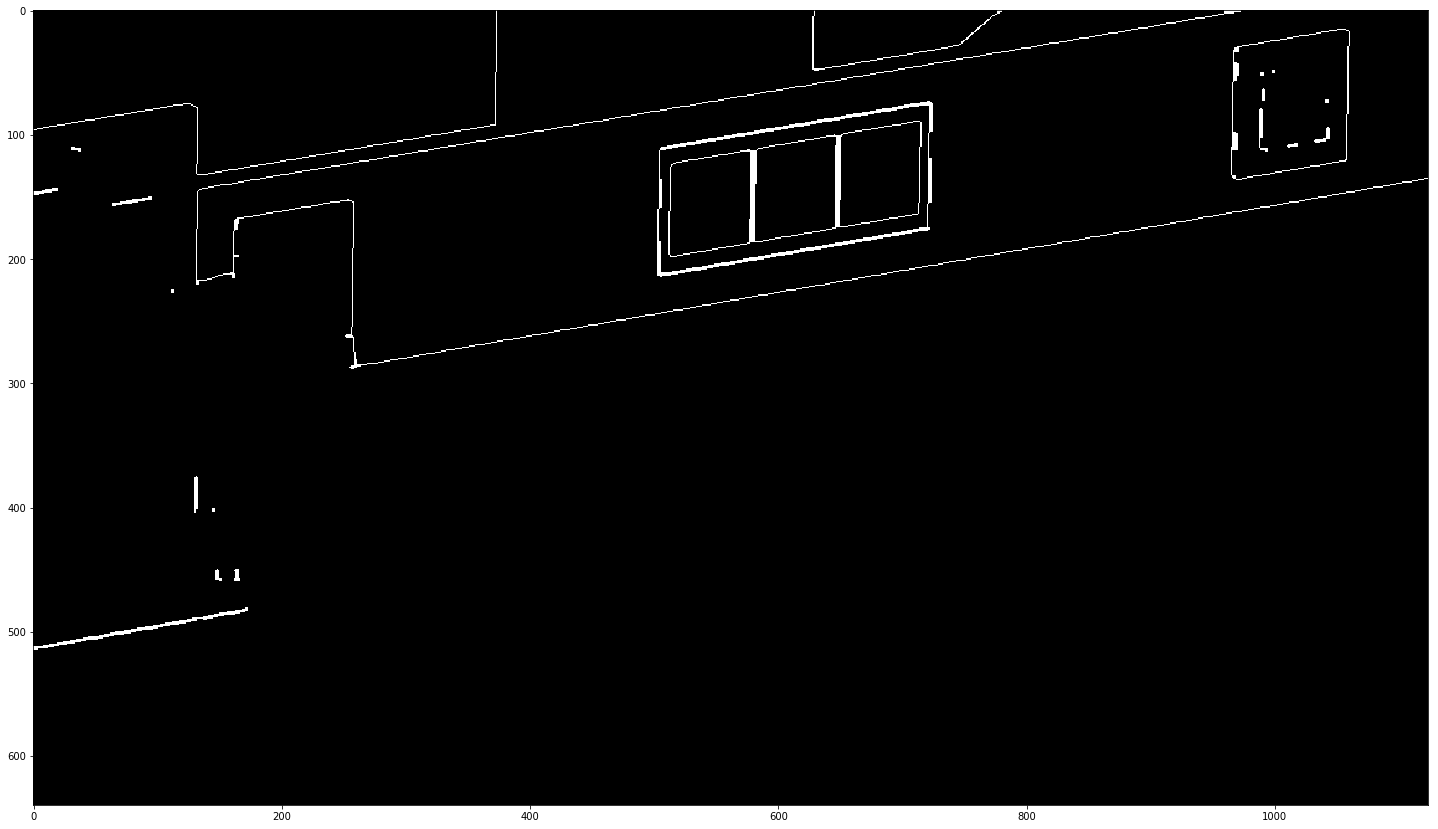

In [434]:
img_sat, mask = cv2.threshold(img_canny, 1, 255, cv2.THRESH_BINARY)
kern2=np.ones((5,5),np.uint8)
img_delated = cv2.dilate(mask,kern2)
img_eroded = cv2.erode(img_delated,kern2)
plt.figure(figsize = (25,25))
plt.imshow(img_eroded, cmap='gray')


Il est temps d'extraire les contours à partir de l'image en réalisant une approximation sipple en chaine.

In [426]:
im2, contours, hierarchy = cv2.findContours(img_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

On superpose les contours sur l'image

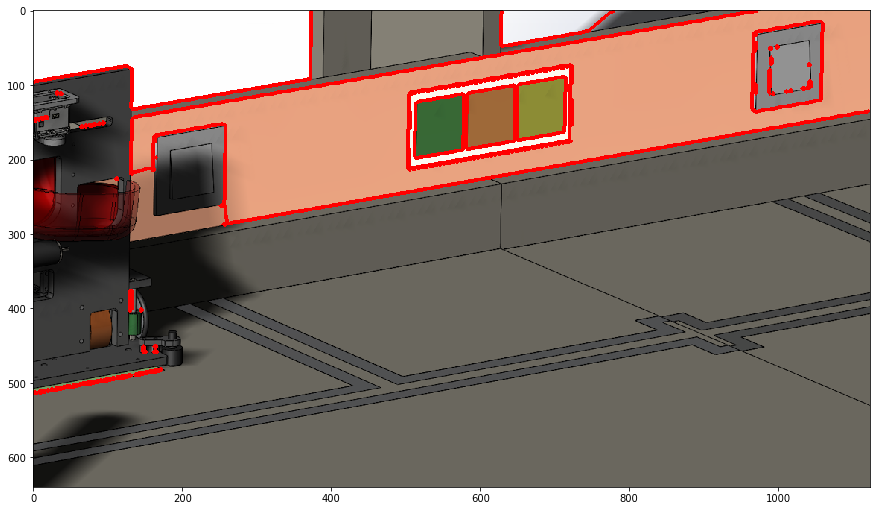

In [427]:
img_contoured=img.copy()
cv2.drawContours(img_contoured, contours, -1, (255,0,0), 3)
plt.figure(figsize = (15,15))
plt.imshow(img_contoured)

Bon, on voit qu'il ya trop de contours.
Faisons le tri :
- Que des contours pouvant etre approximés par 4 points (des rectangles quoi!)
- On ajoute aussi une condition sur la taille du rectangle.
- On calcule le contre de chaque rectangle.
- On reviens sur l'image d'origine qu'on convertie en hsv (plus simple si on veut classifier les couleurs par la suite)
- On affiche le cercle qui encadre chaque carré détecté
- On construit une liste des carrés

In [428]:
img_contoured_onlyrects=img.copy()
nb_detectedRects=0
# Short distance best configuration
# min_radius = 45
# vmax_radius = 60
# Long distance best configuration
min_radius = 10
max_radius = 200
# prepare lists of colors, radii and centers
centers=np.empty([0, 2])
radii = np.empty([0, 1])
colors=np.empty([0, 3])
# Now loop through all contours to select the best ones
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if(len(approx)==4):
        (x,y),radius = cv2.minEnclosingCircle(approx)
        tcenter = (int(x),int(y))
        center = np.array([[int(x),int(y)]])
        radius = int(radius)
        # Detect only new rectagles
        if not(center in centers) and radius>min_radius and radius<max_radius:
            #print(approx)
            # detect parallelipipeds
            v1=approx[1,:]-approx[0,:]
            v2=approx[3,:]-approx[2,:]
            v3=approx[2,:]-approx[1,:]
            NN = abs(np.linalg.norm(v1)-np.linalg.norm(v2))
            NNN = abs(np.linalg.norm(v1)-np.linalg.norm(v3))
            N = np.linalg.norm(np.cross(v1,v2))
            print("v1 = {}, v2={}, N={}, NN={}, NNN={}".format(v1,v2,N,NN,NNN))
            if(NNN<100 and NN<10 and N<100):       
                cv2.drawContours(img_contoured_onlyrects, [approx], -1, (0, 0, 255),2)
                centers = np.append(centers, center,axis=0)
                radii = np.append(radii, np.reshape(radius,(1,1)),axis=0)

                nb_detectedRects = nb_detectedRects + 1

                img_hsv = cv2.cvtColor(img_rw, cv2.COLOR_BGR2HSV)
                # Extract color            
                securityDiv = 4
                startX = int(x-radius/securityDiv)
                endX = int(x+radius/securityDiv)
                startY = int(y-radius/securityDiv)
                endY = int(y+radius/securityDiv)

                subImg=img_hsv[startY:endY, startX:endX,:]
                center_color = img_hsv[int(y), int(x)]
                color = np.average(np.average(subImg, axis= 0), axis= 0)
                color = np.reshape(color, (1,3)).astype(int)
                colors = np.append(colors, color,axis=0)
                # Extract hue
                hue=color[0]
                print("{} : rectangle found at {} with center color{} and mean color {} and size {}\n".format(nb_detectedRects, center,center_color, color, radius))



v1 = [[ 0 26]], v2=[[-8  0]], N=208.0, NN=18.0, NNN=17.93774225170145
v1 = [[-63  12]], v2=[[ 64 -11]], N=75.0, NN=0.8057574009210242, NNN=9.874081469017696
1 : rectangle found at [[545 155]] with center color[ 58 125 104] and mean color [[ 58 124 103]] and size 53

v1 = [[-21   6]], v2=[[   1 -100]], N=2094.0, NN=78.16467020716469, NNN=78.16467020716469
v1 = [[-65  12]], v2=[[ 64 -11]], N=53.0, NN=1.1599790984260778, NNN=6.901588521357041
2 : rectangle found at [[614 143]] with center color[ 14 163 158] and mean color [[ 14 163 158]] and size 53

v1 = [[-63  11]], v2=[[ 63 -11]], N=0.0, NN=0.0, NNN=10.053648627035628
3 : rectangle found at [[682 131]] with center color[ 30 158 140] and mean color [[ 30 157 139]] and size 53

v1 = [[-2 97]], v2=[[30 -3]], N=2904.0, NN=66.87098950243868, NNN=68.57769105914556


On trie les couleurs de gauche à droite

[0 1 2]
Detected 3 rectangles


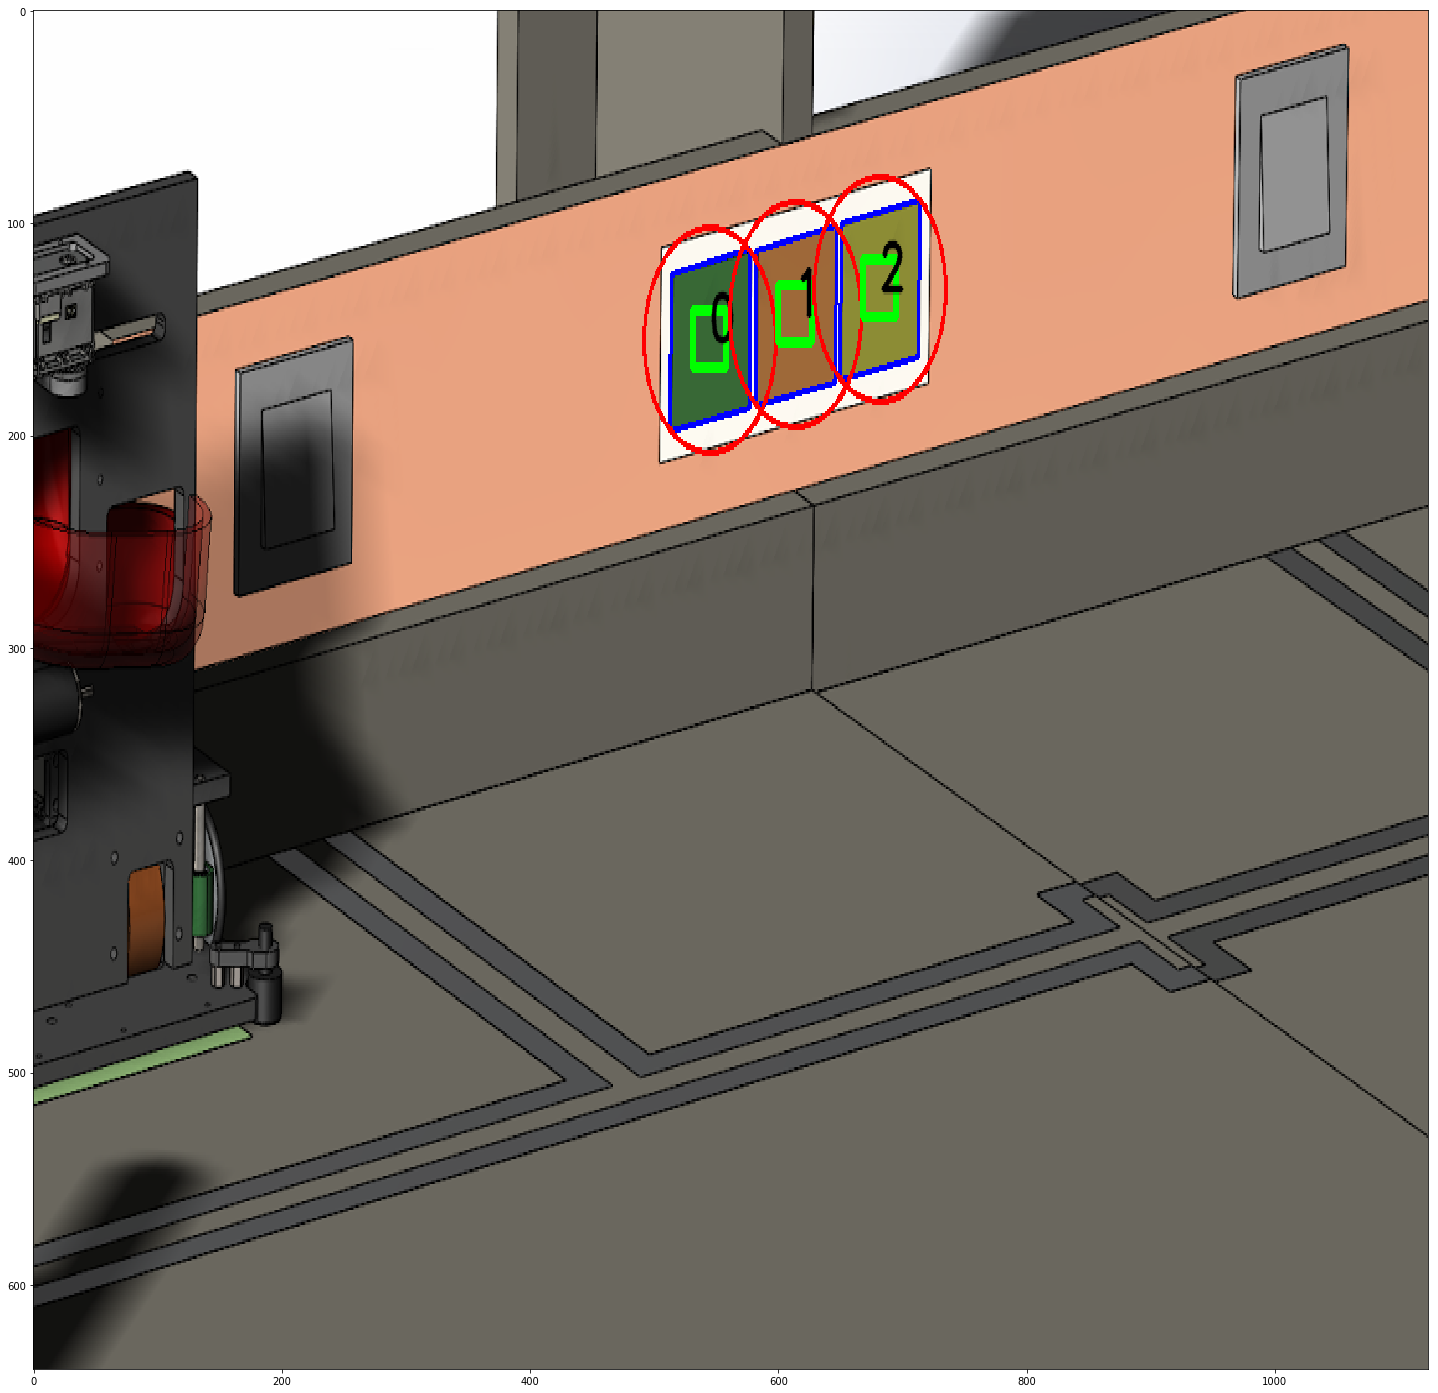

In [429]:
indices = np.argsort(centers[:,0], axis=0) 
print(indices)
                
                
for i in range(0,len(centers)):
    radius = radii[indices[i]]
    securityDiv = 4
    x = centers[indices[i],0]
    y = centers[indices[i],1]
    tcenter = (int(x),int(y))
    startX = int(x-radius/securityDiv)
    endX = int(x+radius/securityDiv)
    startY = int(y-radius/securityDiv)
    endY = int(y+radius/securityDiv)
    cv2.rectangle(img_contoured_onlyrects,(startX,startY),(endX,endY),(0,255,0),3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_contoured_onlyrects, str(i),(int(x),int(y)), font, 1,(0,0,0),2,cv2.LINE_AA)
    cv2.circle(img_contoured_onlyrects,tcenter,radius,(255,0,0),2)
                
# Now we do have all needed data about 
# Let's sort our centers     
plt.figure(figsize = (25,25))
plt.imshow(img_contoured_onlyrects, interpolation='nearest', aspect='auto')
print("Detected {} rectangles".format(nb_detectedRects))

On définie une distance entre les couleurs en hsv

In [430]:
def hsv_dist(ref, color):
    dh = color[0]-ref[0]
    # ds = color[1]-ref[1]
    return np.sqrt(dh*dh)#+dv*dv)


On définit la liste des couleurs de référence

In [431]:
# Black, Yellow, Green, Blue, Orange
# Convert hue from degrees to 255 base
# 0.71 = 255/360
ref=[[0,0,0],[54*0.71,0,0],[100*0.71,0,0],[210*0.71,0,0],[25*0.71,0,0]]
refNames =['Black','Yellow','Green','Blue','Orange']


On crée une fonction qui donne l'indice de la couleur dans la liste des références.

In [432]:
#find the color name
def findColorName(color):
    index = 0
    dist  = hsv_dist(ref[0], color)
    for i in range(1,np.shape(ref)[0]):
        newDist = hsv_dist(ref[i], color)
        if(newDist<dist):
            index = i
            dist = newDist
    return  index

On vérifie qu'on a bien détecté 3 carrés, et si oui, on extrait les indices des couleurs

In [433]:
if(np.shape(indices)[0]!=3):
    print("Error !!! more than one rect was found")
else :
    print("Found 3 colors")
    print(colors)
    for i in range(0,3):
        colorIndex = findColorName(colors[i,:])
        print("{} : {}".format(i, refNames[colorIndex]))
        

Found 3 colors
[[  58.  124.  103.]
 [  14.  163.  158.]
 [  30.  157.  139.]]
0 : Green
1 : Orange
2 : Yellow


Et voila!!

On a extrait nos rectangles ainsi que leurs couleurs respectifs en mode Texte
